In [43]:
import pandas as pd
import numpy as np

In [44]:
# Read dataset
df = pd.read_csv("../data/song_properties_dataset.csv")

In [45]:
# Dropping unspecified artists 
df = df[df["artist_name"] != "['Unspecified']"]

In [46]:
# Filter out speeches, comedy routines, poems, etc.
# .66 as per suggested by Spotify
df = df[df["speechiness"] < 0.66]

# Exploratory Data Analysis

In [47]:
df.head(10)

,id,genre,track_name,artist_name,danceability,valence,energy,tempo,loudness,speechiness,instrumentalness
0,6wN5nWLgjEGmPwozDh2jwM,acoustic,Kiss Me,Jason Walker,0.429,0.330,0.184,77.567,-9.731,0.0299,0.000000
1,5z1vCywwTJAP8qSkGJymFY,acoustic,Creep - Live,Korn,0.484,0.236,0.534,104.023,-8.156,0.1510,0.000000
2,1ZmbLKxfrWh2ejFjiZxZPW,acoustic,Better Off - Live From Spotify London,HAIM,0.510,0.419,0.702,119.296,-10.475,0.0296,0.003800
3,7noCkklUhEAoj8GJkbAuHq,acoustic,All of Me,Boyce Avenue,0.606,0.308,0.209,125.969,-10.273,0.0418,0.000000
4,6wDKGtbPpF9xPMRv7bswQN,acoustic,Dead Sea,The Lumineers,0.713,0.472,0.319,94.043,-11.077,0.0289,0.000079
5,7nnWIPM5hwE3DaUBkvOIpy,acoustic,Drive,Incubus,0.645,0.666,0.792,90.565,-6.862,0.1900,0.000000
6,2izoqbHZCGaoFOO8vcc1hK,acoustic,Boyfriend,Alex G,0.781,0.741,0.737,93.077,-12.636,0.0638,0.000037
7,0GNI8K3VATWBABQFAzBAYe,acoustic,Stay,Rihanna,0.621,0.125,0.310,111.893,-9.903,0.0308,0.000025
8,0VxFKXvKLjYWU7oPPMwzuN,acoustic,Somewhere Only We Know,Keane,0.457,0.389,0.646,172.257,-10.132,0.0379,0.010900
9,11ETYjIGagOXU1PtCmF3T2,acoustic,Stuck In The Moment,Justin Bieber,0.718,0.452,0.709,90.026,-11.566,0.2180,0.000162


In [48]:
import seaborn as sns; sns.set_theme()

<AxesSubplot:>

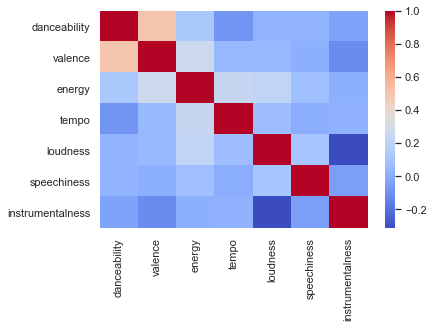

In [49]:
sns.heatmap(df.corr(), cmap = "coolwarm")

In [50]:
df.dropna(inplace=True)

# Preprocessing

In [51]:
# Drop duplicates
df.drop_duplicates(subset = "id", keep = "first", inplace = True)

# Drop song duplicates
def drop_duplicates(df):
    df['artists_song'] = df.apply(lambda row: row['artist_name']+row['track_name'],axis = 1)
    return df.drop_duplicates('artists_song')

track_df = drop_duplicates(df)
print("Are all songs unique: ",len(pd.unique(track_df.artists_song))==len(track_df))

Are all songs unique:  True


In [52]:
# Converting genres columns into a list
def genre_preprocess(df):
    '''
    Preprocess the genre data
    '''
    df['genres_list'] = df['genre'].apply(lambda x: x.split(" "))
    return df
track_df = genre_preprocess(track_df)
track_df['genres_list'].head()

0    [acoustic]
1    [acoustic]
2    [acoustic]
3    [acoustic]
4    [acoustic]
Name: genres_list, dtype: object

In [53]:
# Preporcessing new playlist
def playlist_preprocess(df):
    '''
    Preprocess imported playlist
    '''
    df = drop_duplicates(df)
    df = select_cols(df)
    df = genre_preprocess(df)

    return df

# Feature Engineering

In [54]:
from textblob import TextBlob

# Preparing for sentiment analysis, will devide by subjectivity (0,1) v polarity (-1,1)
def getSubjectivity(text):
  '''
  Getting the Subjectivity using TextBlob
  '''
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  '''
  Getting the Polarity using TextBlob
  '''
  return TextBlob(text).sentiment.polarity

def getAnalysis(score, task="polarity"):
  '''
  Categorizing the Polarity & Subjectivity score
  '''
  if task == "subjectivity":
    if score < 1/3:
      return "low"
    elif score > 1/3:
      return "high"
    else:
      return "medium"
  else:
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

def sentiment_analysis(df, text_col):

  df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
  df['polarity'] = df[text_col].apply(getPolarity).apply(getAnalysis)
  return df

In [55]:
sentiment = sentiment_analysis(track_df, "track_name")
sentiment.head()

,id,genre,track_name,artist_name,danceability,valence,energy,tempo,loudness,speechiness,instrumentalness,artists_song,genres_list,subjectivity,polarity
0,6wN5nWLgjEGmPwozDh2jwM,acoustic,Kiss Me,Jason Walker,0.429,0.330,0.184,77.567,-9.731,0.0299,0.000000,Jason WalkerKiss Me,[acoustic],low,Neutral
1,5z1vCywwTJAP8qSkGJymFY,acoustic,Creep - Live,Korn,0.484,0.236,0.534,104.023,-8.156,0.1510,0.000000,KornCreep - Live,[acoustic],high,Positive
2,1ZmbLKxfrWh2ejFjiZxZPW,acoustic,Better Off - Live From Spotify London,HAIM,0.510,0.419,0.702,119.296,-10.475,0.0296,0.003800,HAIMBetter Off - Live From Spotify London,[acoustic],high,Positive
3,7noCkklUhEAoj8GJkbAuHq,acoustic,All of Me,Boyce Avenue,0.606,0.308,0.209,125.969,-10.273,0.0418,0.000000,Boyce AvenueAll of Me,[acoustic],low,Neutral
4,6wDKGtbPpF9xPMRv7bswQN,acoustic,Dead Sea,The Lumineers,0.713,0.472,0.319,94.043,-11.077,0.0289,0.000079,The LumineersDead Sea,[acoustic],high,Negative


## One Hot Encoding

In [56]:
def ohe_prep(df, column, new_name): 
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [57]:
# One-hot encoding for the subjectivity 
subject_ohe = ohe_prep(sentiment, 'subjectivity','subject')
subject_ohe.iloc[0]

subject|high      0
subject|low       1
subject|medium    0
Name: 0, dtype: uint8

## TF-IDF

To address multiple genres

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(track_df['genres_list'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
#genre_df.drop(columns='genre|unknown')
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

genre|acoustic       1.0
genre|afrobeat       0.0
genre|age            0.0
genre|alt            0.0
genre|alternative    0.0
                    ... 
genre|trip           0.0
genre|tunes          0.0
genre|turkish        0.0
genre|work           0.0
genre|world          0.0
Name: 0, Length: 129, dtype: float64

# Content Based Filtering

In [59]:
# Importing relevant libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re

In [60]:
# Test playlist
playlistDF_test = pd.read_csv("../data/test_playlist.csv")
#playlistDF_test = playlist_preprocess(playlistDF_test)
playlistDF_test.head()

,id,genre,track_name,artist_name,danceability,valence,energy,tempo,loudness,speechiness,instrumentalness
0,2rgqPSIRAfaO2MGo9smdSX,children,Dancing Queen,ABBA,0.545,0.162,0.675,124.970,-7.596,0.0323,0.000263
1,2TjNlK2tNBxF8C8RIaK9Gb,disco,Gimme! Gimme! Gimme! (A Man After Midnight),ABBA,0.639,0.562,0.869,133.033,-6.438,0.0339,0.000000
2,22NN4BS1AlqVbyKIWExgON,groove,Mamma Mia,ABBA,0.431,0.190,0.723,130.141,-8.103,0.0254,0.000000
3,2ATDkfqprlNNe9mYWodgdc,groove,Dancing Queen,ABBA,0.902,0.857,0.839,118.485,-7.364,0.0367,0.000003
4,6vQN2a9QSgWcm74KEZYfDL,groove,Take A Chance On Me,ABBA,0.522,0.199,0.441,130.133,-9.843,0.0712,0.029400


In [61]:
def generate_playlist_feature(complete_feature_set, playlist_df):
    '''
    Summarize a user's playlist into a single vector
    ---
    Input: 
    complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
    playlist_df (pandas dataframe): playlist dataframe
        
    Output: 
    complete_feature_set_playlist_final (pandas series): single vector feature that summarizes the playlist
    complete_feature_set_nonplaylist (pandas dataframe): 
    '''
    
    # Find song features in the playlist
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]
    # Find all non-playlist song features
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]
    complete_feature_set_playlist_final = complete_feature_set_playlist.drop(columns = "id")
    return complete_feature_set_playlist_final.sum(axis = 0), complete_feature_set_nonplaylist

In [62]:
# Generate the features
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlistDF_test)


NameError: name 'complete_feature_set' is not defined

In [ ]:
# Non-playlist features
complete_feature_set_nonplaylist.head()

In [ ]:
# Summarized playlist features
complete_feature_set_playlist_vector

In [ ]:
def generate_playlist_recos(df, features, nonplaylist_features):
    '''
    Generated recommendation based on songs in aspecific playlist.
    ---
    Input: 
    df (pandas dataframe): spotify dataframe
    features (pandas series): summarized playlist feature (single vector)
    nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Output: 
    non_playlist_df_top_40: Top 40 recommendations for that playlist
    '''
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    # Find cosine similarity between the playlist and the complete song set
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    
    return non_playlist_df_top_40

In [ ]:
# Genreate top 10 recommendation
recommend = generate_playlist_recos(songDF, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)
recommend.head(10)

In [ ]:
playlistDF_test[["artist_name","track_name"]][:20]
